# PSHA Disaggregation Validation 

### This notebook will serve as a PSHA disaggregation valdidation for the ucla_plha repository. A PSHA disaggregration for the BSSA 2014 model will be shown. A comprabale disaggregation from OpenSHA and the NSHMP will aslo be provided. 

/var/folders/sp/_lw3kwhs0tg4bbdq5gwc1wmh0000gn/T/ipykernel_56636/3278335521.py:114: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.86)
/var/folders/sp/_lw3kwhs0tg4bbdq5gwc1wmh0000gn/T/ipykernel_56636/3278335521.py:116: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(out_png, dpi=dpi)


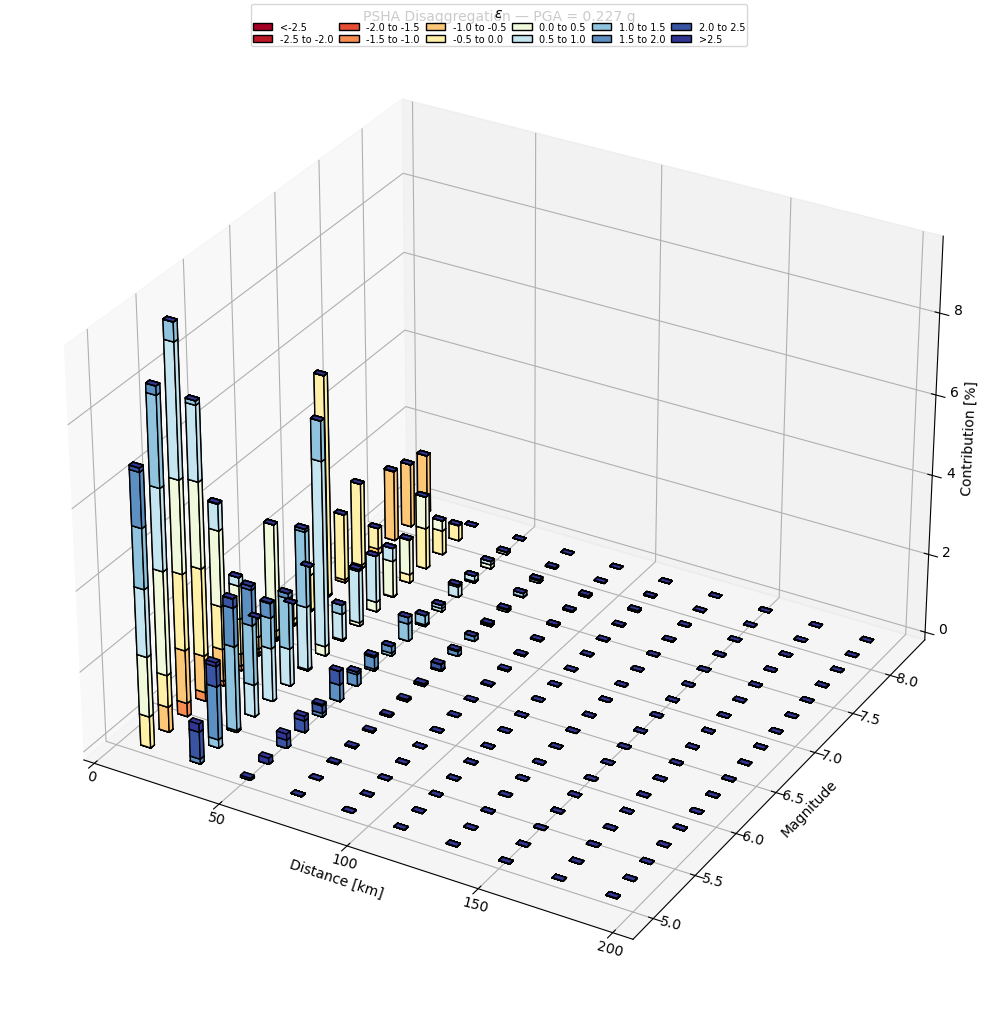

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Configuration
json_path = "output_disaggregation.json"
pga_index = 9
out_png = "psha_disagg.png"
dpi = 300

# Load data
with open(json_path, "r") as f:
    output_data = json.load(f)

# Extract bin edges
magnitude_bin_edges = np.asarray(
    output_data["input"]["output"]["psha"]["disaggregation"]["magnitude_bin_edges"], dtype=float
)
distance_bin_edges = np.asarray(
    output_data["input"]["output"]["psha"]["disaggregation"]["distance_bin_edges"], dtype=float
)
epsilon_bin_edges = np.asarray(
    output_data["input"]["output"]["psha"]["disaggregation"]["epsilon_bin_edges"], dtype=float
)
pga = np.asarray(output_data["input"]["output"]["psha"]["pga"], dtype=float)

# Extract disaggregation data
disagg_psha = np.asarray(output_data["output"]["psha"]["disaggregation"], dtype=float)

# Bar dimensions
depth_plot = (magnitude_bin_edges[1] - magnitude_bin_edges[0]) * 0.2
width_plot = (distance_bin_edges[1] - distance_bin_edges[0]) * 0.2

# Calculate centers for epsilon (used for coloring)
epsilon_center = 0.5 * (epsilon_bin_edges[:-1] + epsilon_bin_edges[1:])

# Position bars at bin edges (not centers) - this aligns ticks properly
m_center = 0.5 * (magnitude_bin_edges[:-1] + magnitude_bin_edges[1:])
r_center = 0.5 * (distance_bin_edges[:-1] + distance_bin_edges[1:])
m_center = m_center + 0.5 * (magnitude_bin_edges[:-1] - magnitude_bin_edges[1:])  # shifts to left edge

# Create mesh grid for bar positions
_xx, _yy = np.meshgrid(r_center, m_center)
x, y = _xx.ravel(), _yy.ravel()

# Colormap setup
my_cmap = plt.get_cmap("RdYlBu_r")

def rescale_for_cmap(e):
    hi = epsilon_bin_edges[1] if len(epsilon_bin_edges) > 1 else epsilon_bin_edges[0]
    lo = epsilon_bin_edges[-2] if len(epsilon_bin_edges) > 2 else epsilon_bin_edges[-1]
    return 0.5 if hi == lo else (e - lo) / (hi - lo)

def epsilon_label(i):
    if i == 0 and len(epsilon_bin_edges) > 1:
        return f"<{epsilon_bin_edges[1]}"
    elif i == len(epsilon_center) - 1 and len(epsilon_bin_edges) > 2:
        return f">{epsilon_bin_edges[-2]}"
    else:
        return f"{epsilon_bin_edges[i]} to {epsilon_bin_edges[i+1]}"

# Create figure
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1, projection="3d")

# Plot stacked bars for each epsilon bin
bottom = np.zeros(len(x))
for i, e in enumerate(epsilon_center):
    top = disagg_psha[pga_index, :, :, i].ravel()
    ax.bar3d(
        x, y, bottom, width_plot, depth_plot, top,
        shade=True, zsort="max", edgecolor="black",
        facecolor=my_cmap(rescale_for_cmap(e)),
    )
    bottom += top

# Labels and formatting
ax.set_title(f"PSHA Disaggregation — PGA = {np.round(pga[pga_index], 3)} g", pad=-5, fontsize=10)
ax.set_xlabel("Distance [km]", labelpad=-5)
ax.set_ylabel("Magnitude", labelpad=-5)
ax.set_zlabel("Contribution [%]", labelpad=-5)

# Set ticks
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0])

# Align tick labels properly
for label in ax.get_yticklabels():
    label.set_verticalalignment('center')
    label.set_horizontalalignment('left')
for label in ax.get_xticklabels():
    label.set_verticalalignment('top')
    label.set_horizontalalignment('center')
for label in ax.get_zticklabels():
    label.set_verticalalignment('center')
    label.set_horizontalalignment('center')

ax.tick_params(axis="x", pad=-5, rotation=-15)
ax.tick_params(axis="y", pad=-5, rotation=-15)
ax.tick_params(axis="z", pad=0)

# Legend
legend_handles = [
    Patch(facecolor=my_cmap(rescale_for_cmap(e)), edgecolor="black", label=epsilon_label(i))
    for i, e in enumerate(epsilon_center)
]
legend_labels = [epsilon_label(i) for i in range(len(legend_handles))]
fig.legend(
    legend_handles, legend_labels,
    loc="upper center",
    title=r"$\varepsilon$", fontsize=7, ncols=6, borderpad=0.2, labelspacing=0.2, columnspacing=0.6
)
fig.subplots_adjust(top=0.86)

plt.savefig(out_png, dpi=dpi)
plt.show()

# OpenSHA validation 
## To provide a validation for our sesismic hazard disaggregation we can use OpenSHA (Field, 2003) to plot a disaggregation. 

<img src="Disagg_1.png" width="1000">


## These four screenshots provide the inputs for the OpenSHA disaggregation 


<img src="Disagg_2.png" width="500">
<img src="Disagg_3.png" width="500">
<img src="Disagg_4.png" width="500">
<img src="Disagg_5.png" width="500">

## Here is the disaggregration specific inputs for OpenSHA- note magntiude and distance bin centers are used 

<img src="Disagg_6.png" width="500">

## Note: The results won't match perfectly as ucla_plha does not use same background scenarios as the updated version of UCERF3 which has actual fault realizations for the background sources